# Project #7 : Implement a scoring model

The aim of this project is to build a scoring model that will be able to give the probability that a client fail in his installment payments. Hence, for the project purpose, we are supposed to work as a data scientist in fictitious company *Prêt à dépenser* which proposes loans to clients that don't have consequent background in credit application. The data are retrieved from this link:
www.kaggle.com/c/home-credit-default-risk/data

This notebook is the second part of our analysis and is concerned with the modelling. The first ones dealt with the preprocessing of the data.

## Outline
1. Prepare the data for the modeling
    1. Load the data
    2. Resampling
    3. Feature selection
2. Modeling
    1. Logistic regression : Baseline model
    2. Decision tree
    3. Random Forest
    4. LGBM Classifier
3. Final model
    1. Comparison of the model performances
    2. Feature ranking
    3. Store the final results
4. Interpreability of the predictions with Lime

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Set the working directory
import os
os.chdir("/content/gdrive/My Drive/Colab_Notebooks/")

In [0]:
# Load the used packages and set the workplace

%matplotlib inline

# Standard libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# memory usage
import gc
import pickle

# data preprocessings
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

# data resampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.ensemble import BalancedBaggingClassifier

# Performance evaluation
from sklearn import metrics
from sklearn.metrics.scorer import make_scorer

# Classification models
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb


# Hyperparameters tuning
## Manual tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
## Automatic fine tuning
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import tpe, Trials, fmin

# Interpretability of the predictions
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFpr, f_classif

# load the written functions for this project
import modules_projet7 as mp

#import warnings  # hide warning message
#warnings.filterwarnings("ignore")

In [5]:
os.getcwd()

'/content/gdrive/My Drive/Colab_Notebooks'

# Prepare the data for the modeling

The EDA (exploratory data analysis) shows that we have unbalanced data which is aa severe drawback for the modeling. Hence, before carrying out the modeling, we will:
- **Set the X and y arrays**
- **Split the dataset into training and testing sets**
- **Impute missing values with an imputer**
- **Standardize with a scaler**
- **Resample the data with the *imblearn* package**
- **Reduce the number of features with an automatic feature selection method**

## Load the data

In [6]:
# Reload the cleaned training set
train_set = pd.read_csv('./train_set.csv', sep=',')
train_set = mp.convert_types(train_set)

Original Memory Usage: 1.038 gb.
New Memory Usage: 0.519 gb.


In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 422 entries, AMT_ANNUITY to WEEKDAY_APPR_PROCESS_START=WEDNESDAY
dtypes: float32(253), int32(169)
memory usage: 495.0 MB


In [8]:
train_set.head()

AMT_ANNUITY  ...  WEEKDAY_APPR_PROCESS_START=WEDNESDAY
0      24700.5  ...                                     1
1      35698.5  ...                                     0
2       6750.0  ...                                     0
3      29686.5  ...                                     1
4      21865.5  ...                                     0

[5 rows x 422 columns]

In [9]:
# Set X and y 
X = train_set.loc[:,~train_set.columns.isin(['SK_ID_CURR', 'TARGET'])]
y = train_set['TARGET']

print(X.shape, y.shape)

(307511, 420) (307511,)


In [0]:
# Split X and y in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Inputer of missing values with mean
impute_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Normalize with a standard scaler
scaler = preprocessing.StandardScaler()

# Fit the imputer and the scaler to X_train and transform the data
X_train_std = scaler.fit_transform(impute_mean.fit_transform(X_train))
X_test_std = scaler.transform(impute_mean.transform(X_test))

print(X_train_std.shape)
print(X_test_std.shape)

(246008, 420)
(61503, 420)


## Resampling

There is an unequal distribution of classes (bad and good clients) in the dataset. We need to fix this unbalanced problem in the train set before carrying out the classification. Here are some approaches that will be tested, we will use the one which gives the best performance.

**Undersampling the majority class:** remove randomly some of the observations from the majority class in order to match the numbers with the minority class

**Oversampling the minority class:** create randomly a sample with replacement of the minority class 

**SMOTE (Synthetic Minority Over-sampling):** genetares synthetic data that tries to randomly generate a sample of the attributes from the observations in the minority class. SMOTE uses k-nearest neighbours algorithm to generate new and synthetic data.

for the resampling, we use the **SMOTE** and the **RandomUnderSampler** algorithms of the **imblearn** package. *RandomUnderSampler* is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes.

In [0]:
# Generic synthetic over sampling with SMOTE
# strategy option: 'minority', 'auto', 
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_std, y_train)

# Controlled under-sampling techniques with RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_std, y_train)

In [13]:
print("Random under sampling shape", X_rus.shape)
print("Smote over sampling shape", X_train_sm.shape)

Random under sampling shape (39752, 420)
Smote over sampling shape (452264, 420)


Text(0.5, 1.0, 'Balanced classes')

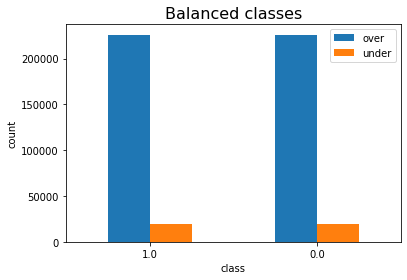

In [14]:
tab = pd.DataFrame({"over":pd.Series(y_train_sm).value_counts(),
              "under": pd.Series(y_rus).value_counts()})

fig, ax = plt.subplots()
tab.plot.bar(ax=ax, rot=0)
ax.set_xlabel('class')
ax.set_ylabel('count')
ax.set_title("Balanced classes", fontsize=16)

In [0]:
# Train a logistic regression object on the two balanced samples and compare the performance
lr = LogisticRegression(solver='liblinear',random_state=42)

# Fit to the unbalanced training set
lr.fit(X_train_std, y_train)
baseline_y_pred = lr.predict(X_test_std)

# Fit to training data banlanced by undersampling
lr.fit(X_rus, y_rus)
rus_y_pred = lr.predict(X_test_std)

# Fit to training data banlanced by oversampling with SMOTE
lr.fit(X_train_sm, y_train_sm)
sm_y_pred = lr.predict(X_test_std)

In [16]:
# Validation performance : RECALL SCORE
print("recall score\n------------------")
print("baseline : %0.3f" % metrics.recall_score(y_test, baseline_y_pred))
print("random under-sampling : %0.3f" % metrics.recall_score(y_test, rus_y_pred))
print("SMOTE over-sampling : %0.3f" % metrics.recall_score(y_test, sm_y_pred))

recall score
------------------
baseline : 0.016
random under-sampling : 0.675
SMOTE over-sampling : 0.652


We found that the results are really bad with unbalanced data and that the undersampling gives the highest recall score on validation data. Of course there is not a big difference with the oversampling performance. But, we will continue with the undersampling data. The drawback associated with the oversampling is that it introduces noise in the data by generating synthetic data, while the inconvenient with the undersampling is that we loose nearly 80 percent of the entries. But, in our case this is not that bad as we still have a consequent number of entries.

## Feature selection

We use an automatic method to select relevant features using the False Positive Rate (FPR) test. The FPR test controls the total amount of false detections. We use alpha = 1% as a filter to keep features with pvalues below alpha. The ANOVA F-value has been used as the scoring function.

In [19]:
selection = SelectFpr(f_classif, alpha=0.01).fit(X_rus, y_rus)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [50 95 96] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [28]:
X_train.iloc[:,[50,95]].head()

client_cash_NAME_CONTRACT_STATUS_XNA_mean_min  client_NAME_GOODS_CATEGORY_Animals_mean
123473                                            0.0                                      0.0
10118                                             0.0                                      0.0
64716                                             0.0                                      0.0
234940                                            0.0                                      0.0
236051                                            0.0                                      0.0

In [0]:
feature_to_drop = ['client_cash_NAME_CONTRACT_STATUS_XNA_mean_min',
                  'client_NAME_GOODS_CATEGORY_Animals_mean']

In [20]:
mask = selection.get_support()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:592: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha


In [29]:
X_select = X_train.loc[:,mask].copy()
X_select.head()

AMT_ANNUITY  ...  WALLSMATERIAL_MODE=Stone, brick
123473      16366.5  ...                                0
10118       23638.5  ...                                1
64716       25173.0  ...                                0
234940      36787.5  ...                                0
236051      21294.0  ...                                0

[5 rows x 221 columns]

**199 features have been removed.**

In [0]:
# check that the two features with warning (only one value) have been removed
for col in X_select.columns:
    if col in feature_to_drop:
        print(col)

In [34]:
# Keep the important features and use the resampled data
X_train_std = selection.transform(X_rus)
X_test_std = selection.transform(X_test_std)

print(X_train_std.shape)
print(X_test_std.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:592: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:592: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha


(39752, 221)
(61503, 221)


In [0]:
# re-affect the y_train
y_train = y_rus

# Modeling

We will test four classification models:
- Logistic regression: used as a baseline model
- Decision tree
- Random forest
- Litgh GBM classifier

Since, the aim of this analysis is to carry out a scoring model and predict the probability that client is good or bad client, it is rather better for the bank to minimize the **false negative ratio (FNR)**, in other words maximise the true positive rate. FNR = 1 - TPR.

The true positive ratio (a.k.a **recall score**) is the ratio tp/(tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.The higher is the recall score, better is the classifier performance.

In [0]:
# Define a loss (or score) function fot the tuning

def fnr_cm(trues, preds):
    """Customize a scorer function for the tuning of a grid of hyperparameters
    using the confusion matrix
    Parameters:
        true: true labels
        preds: predict labels
    Returns:
        fnr: false negative"""
    
    # calculate the confusion matrix
    cm = metrics.confusion_matrix(trues, preds)
    
    # Normalize the confusion matrix
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    
    # Extract the normalize true negatives, false positive, false negative, true positive
    tnr, fpr, fnr, tpr = cm.ravel()
    
    # Return the false negative
    return fnr

def fnr_prob(trues, prob):
    """Customize a scorer function for the tuning of a grid of hyperparameters
    using the precision recall curve
    Parameters:
        true: true labels
        prob: predict probabilities
    Returns:
        fnr: false negative"""
    precision, recall, thresholds = metrics.precision_recall_curve(trues, prob[:,1], pos_label=1)
    tpr = np.mean(recall[:-1,])
    fnr = 1 - tpr 
    return fnr

def fnr_pred(trues, preds):
    """Customize a scorer function for the tuning of a grid of hyperparameters
    based on the recall score
    Parameters:
        trues: true labels
        preds: predicted labels
    Returns:
        fnr: false negative ratio"""
    # TPR (recall score = TP/(TP+FN))
    tpr = metrics.recall_score(trues, preds, pos_label=1)
    
    # Return the fnr
    fnr = 1 - tpr
    return fnr

# Transform the custom function to a scorer
my_loss_function = fnr_pred # choose the 1st or the 3rd function
loss_fnr = make_scorer(my_loss_function, greater_is_better=False)

# Set different scorers
#multi_scorer = {
    #'precision_score': make_scorer(metrics.precision_score),
#    'recall_score': make_scorer(metrics.recall_score, greater_is_better=True),
#    'accuracy_score': make_scorer(metrics.accuracy_score),
    #'false_negative': loss
#}

## Logistic regression : Baseline model

In [0]:
# Use the logistic regression as baseline model and fit on the balanced data
baseline = LogisticRegression(solver='liblinear',random_state=42).fit(X_train_std, y_train)

In [40]:
# Validation performance
y_pred = baseline.predict(X_test_std)
acc_score = metrics.accuracy_score(y_test, y_pred)
pre_score = metrics.precision_score(y_test, y_pred, pos_label=1)
re_score = metrics.recall_score(y_test, y_pred, pos_label=1)
fnr = my_loss_function(y_test, y_pred)

print("accuracy score : %0.3f" % acc_score)
print("precision score : %0.3f " % pre_score)
print("recall score : %0.3f" % re_score)
print('false negative ratio : %0.3f' % fnr)

accuracy score : 0.681
precision score : 0.157 
recall score : 0.678
false negative ratio : 0.322


In [60]:
# Use the predicted probability for the evaluation
y_prob = baseline.predict_proba(X_test_std)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_prob[:,1], pos_label=1)
print("accuracy score : %0.3f" % baseline.score(X_test_std, y_test))
print("precision score : %0.3f " % np.mean(precision[:-1,]))
print("recall score : %0.3f" % np.mean(recall[:-1,]))
print("false negative ratio : %0.3f" % fnr_prob(y_test, y_prob))

accuracy score : 0.681
precision score : 0.153 
recall score : 0.724
false negative ratio : 0.276


In [47]:
# Use a dictionary to store the different validation performance results
perf_score = {'accuracy_score': {}, 'precision_score':{}, 'recall_score': {}, 'fnr': {}}
perf_score

{'accuracy_score': {}, 'fnr': {}, 'precision_score': {}, 'recall_score': {}}

In [0]:
def evaluate_performance(prob, estimator, key, data=X_test_std, trues=y_test,
                         dico=perf_score):
    """Function to evaluate the validation performance of an estimator.
    Use standard classification metrics in specifically the recall and the prediction scores.
    The results are stored in a dictionary.
    Parameters:
        trues: arrays, the true labels
        prob: arrays, the predicted probabilities based on the model
        data: array, test set of the features
        estimator: classifier object
        key: string to use in the dictionary
        dico: dictionary, use presetted object
    returns:
        the dictionary
        and print the results"""
    
    # Validation performance
    dico['accuracy_score'][key] = estimator.score(data, trues)
    precision, recall, thresholds = metrics.precision_recall_curve(trues, prob[:,1], pos_label=1)
    dico['precision_score'][key] = np.mean(precision[:-1,])
    dico['recall_score'][key] = np.mean(recall[:-1,])
    dico['fnr'][key] = fnr_prob(trues, prob)
    
    print("accuracy score : %0.3f" % dico['accuracy_score'][key])
    print('false negative ratio : %0.3f' % dico['fnr'][key])
    print("precision score : %0.3f " % dico['precision_score'][key])
    print("recall score : %0.3f" % dico['recall_score'][key])
    #return dico

In [49]:
evaluate_performance(y_prob, baseline, key='Logistic regression')

accuracy score : 0.681
false negative ratio : 0.276
precision score : 0.153 
recall score : 0.724


In [50]:
perf_score

{'accuracy_score': {'Logistic regression': 0.6809098743150741},
 'fnr': {'Logistic regression': 0.27578949511880635},
 'precision_score': {'Logistic regression': 0.1533210791186973},
 'recall_score': {'Logistic regression': 0.7242105048811937}}

In [0]:
# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes=['1','0'],
                         normalize=False,
                         title=True,
                         cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    
    # Compute the confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        title_text = 'Normalized confusion matrix'
    else:
        title_text = 'Confusion matrix, without normalization'
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    if title:
        ax.set_title(title_text)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[38524 18030]
 [ 1595  3354]]


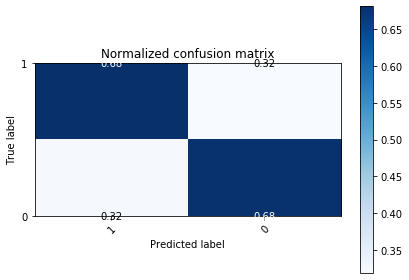

In [55]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(y_test, y_pred, normalize=True)

Text(0.5, 1, 'confusion matrix')

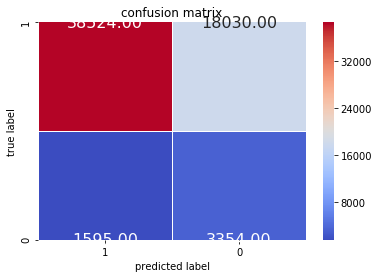

In [53]:
# Plot cm with seaborn
df_cm = pd.DataFrame(cm, index = [i for i in ['1', '0']], columns = [i for i in ['1','0']])

fig, ax = plt.subplots()
sns.heatmap(df_cm, cmap='coolwarm', annot=True, cbar=True,
            linewidth=0.01, fmt='0.2f',
           annot_kws={"size": 16},
           ax=ax)

ax.set_ylabel('true label')
ax.set_xlabel('predicted label')
ax.set_title('confusion matrix')

## Decision tree

### Default parameters

In [61]:
# Set the DecisionTreeClassifier with default parameters
dtc = DecisionTreeClassifier()

# Fit the classifier to the balanced data
dtc.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [62]:
# Validation performance
y_pred = dtc.predict(X_test_std)

print("accuracy score : %0.3f" % metrics.accuracy_score(y_test, y_pred))
print('false negative ratio : %0.3f' % my_loss_function(y_test, y_pred))
print("precision score : %0.3f " % metrics.precision_score(y_test, y_pred))
print("recall score : %0.3f" % metrics.recall_score(y_test, y_pred))

accuracy score : 0.573
false negative ratio : 0.412
precision score : 0.107 
recall score : 0.588


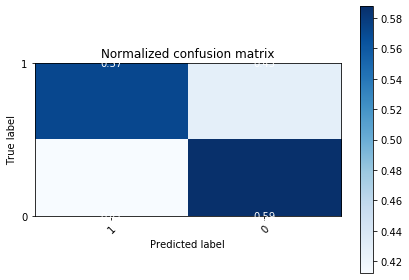

In [63]:
# confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True)

### Hyperparameters tuning with Grid search 

In [0]:
# parameters for a grid search

max_depth = [int(x) for x in np.linspace(10, 110, num=20, endpoint=True)]
max_depth.append(None)

max_features = ['auto', 'sqrt', 'log2', None]
    
params = {
    'max_depth': max_depth,
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features': max_features
}

In [0]:
# Initiate a decision tree object
dtc = DecisionTreeClassifier()

# Grid search
dtc_cv = GridSearchCV(estimator=dtc, param_grid=params, scoring=loss_fnr, cv=5)

In [67]:
dtc_cv.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n...
             param_grid={'max_depth': [10, 15, 20, 25, 31, 36, 41, 46, 52, 57,
                                       62, 67, 73, 78, 83, 88, 94

Text(0.5, 0, 'n_iteration')

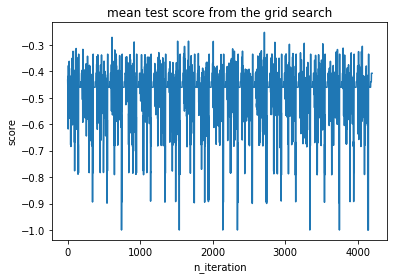

In [69]:
# plot the score values in fonction of the iterations
fig, ax = plt.subplots()
ax.plot(dtc_cv.cv_results_['mean_test_score'])
ax.set_title('mean test score from the grid search')
ax.set_ylabel('score')
ax.set_xlabel('n_iteration')

**As we define a loss, the output of the python function is negated by the scorer object, conforming to the cross validation convention that scorers return higher values for better models.**

In [70]:
dtc_cv.cv_results_['mean_test_score'].max()

-0.2523143489635742

In [71]:
# best parameters after the grid search
dtc_cv.best_params_

{'max_depth': 78,
 'max_features': 'log2',
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.5}

In [72]:
# Re-fit with the best parameters
best_dtc = dtc_cv.best_estimator_
best_dtc.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=78,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.2, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [74]:
# Validation performance

y_pred = best_dtc.predict(X_test_std)
y_prob = best_dtc.predict_proba(X_test_std)

print("accuracy score : %0.3f" % metrics.accuracy_score(y_test, y_pred))
print("precision score : %0.3f " % metrics.precision_score(y_test, y_pred))
print("recall score : %0.3f" % metrics.recall_score(y_test, y_pred))
print('false negative ratio : %0.3f' % my_loss_function(y_test, y_pred))

accuracy score : 0.634
precision score : 0.106 
recall score : 0.477
false negative ratio : 0.523


In [75]:
# Save the results in the precedent dictionary
evaluate_performance(y_prob, best_dtc, key='Decision Tree')

accuracy score : 0.634
false negative ratio : 0.375
precision score : 0.101 
recall score : 0.625


In [76]:
perf_score

{'accuracy_score': {'Decision Tree': 0.6344405963936719,
  'Logistic regression': 0.6809098743150741},
 'fnr': {'Decision Tree': 0.3748231966053748,
  'Logistic regression': 0.27578949511880635},
 'precision_score': {'Decision Tree': 0.10139050502671026,
  'Logistic regression': 0.1533210791186973},
 'recall_score': {'Decision Tree': 0.6251768033946252,
  'Logistic regression': 0.7242105048811937}}

## Random Forest

In [0]:
# Define a grid of hyperparameters for a random search

# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# Number of features
max_features = ['auto', 'sqrt', 'log2', None]
    
params = {
    'n_estimators':n_estimators,
    'max_depth': max_depth,
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features': max_features,
    "bootstrap" : [True],
    "oob_score" : [True]
}

In [0]:
# tuning with random search
rf = RandomForestClassifier()
no_iterations = 100
rf_cv = RandomizedSearchCV(estimator=rf, param_distributions = params,scoring=loss_fnr,
                              n_iter=no_iterations, cv=5, random_state=42, iid=False)

In [84]:
rf_cv.fit(X_train_std, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

Text(0.5, 0, 'n_iteration')

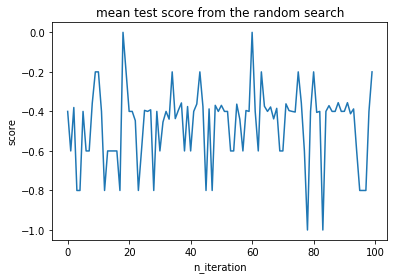

In [85]:
# plot the mean score in fonction of the i-th iteration
fig, ax = plt.subplots()
ax.plot(rf_cv.cv_results_['mean_test_score'])
ax.set_title('mean test score from the random search')
ax.set_ylabel('score')
ax.set_xlabel('n_iteration')

In [86]:
# best parameters after the tuning
rf_cv.best_params_

{'bootstrap': True,
 'max_depth': 83,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.2,
 'min_samples_split': 1.0,
 'n_estimators': 400,
 'oob_score': True}

In [87]:
# Re-fit with the best parameters
best_rf = rf_cv.best_estimator_
best_rf.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=83, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.2, min_samples_split=1.0,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [90]:
# Validation performance

y_pred = best_rf.predict(X_test_std)

print("accuracy score : %0.3f" % metrics.accuracy_score(y_test, y_pred))
print("precision score : %0.3f " % metrics.precision_score(y_test, y_pred))
print("recall score : %0.3f" % metrics.recall_score(y_test, y_pred))
print('false negative ratio : %0.3f' % my_loss_function(y_test, y_pred))

accuracy score : 0.080
precision score : 0.080 
recall score : 1.000
false negative ratio : 0.000


In [122]:
print("training accuracy score : ", best_rf.score(X_train_std, y_train))

training accuracy score :  0.5


In [91]:
# Validation performance
y_prob = best_rf.predict_proba(X_test_std)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_prob[:,1], pos_label=1)
print("accuracy score : %0.3f" % best_rf.score(X_test_std, y_test))
print("precision score : %0.3f " % np.mean(precision[:-1,]))
print("recall score : %0.3f" % np.mean(recall[:-1,]))
print("false negative ratio : %0.3f" % fnr_prob(y_test, y_prob))

accuracy score : 0.080
precision score : 0.080 
recall score : 1.000
false negative ratio : 0.000


In [92]:
# Save the results in the precedent dictionary
evaluate_performance(y_prob, best_rf, key='Random Forest')

accuracy score : 0.080
false negative ratio : 0.000
precision score : 0.080 
recall score : 1.000


**The random forest has a good performance regarding the false negative ratio. However, the accuracy score is really bad on the testing set.**

## LGBM Classifier

### Default hyperparameters

In [93]:
# Default gradient boosting machine classifier
model_lgb = lgb.LGBMClassifier()

# fit the model to the balanced data
model_lgb.fit(X_train_std, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [97]:
# LGBMClassifier output performance
# Use the predicted probability for the evaluation
y_prob = model_lgb.predict_proba(X_test_std)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_prob[:,1])
print("accuracy score : %0.3f" % model_lgb.score(X_test_std, y_test))
print("precision score : %0.3f " % np.mean(precision[:-1,]))
print("recall score : %0.3f" % np.mean(recall[:-1,]))
print('false negative ratio : %0.3f' % fnr_prob(y_test, y_prob))

accuracy score : 0.683
precision score : 0.156 
recall score : 0.728
false negative ratio : 0.272


### Fine tuning with hyperopt

We use *hyperopt* to find the best hyperparameters of LGBM Classifier. We have too many hyperparameters. Applying manual tuning such as a grid (or random) search would take too much time. Automatic tuning is possible with bayesian optimization. The approch finds the value that minimizes an objective function while building a surrogate funtion. The advantage of this approach is that it uses past evaluations results to choose the next parameters to evaluate.

Here are the different steps when using the algorithm:
- define the objective function to minimize
- define the space over which to search
- prepare the database in which to store all the point evaluations of the search
- choose the search algorithm to use

In [0]:
# Create the dataset for the lightgbm
# set free_raw_data to False as we will re-use the data
lgb_train = lgb.Dataset(X_train_std, y_train, free_raw_data=False)
#lgb_test = lgb.Dataset(X_test_std, y_test, reference=lgb_train, free_raw_data=False)

# feature names
lgb_feature_names = [feature for feature in X_select.columns]

In [0]:
# Customize an evaluation loss function for the fine tuning
def custom_eval_function(preds, train_data):
    """Function that customize evaluation
    Parameters:
        preds(list or np 1-D array): the predicted values
        train_data(Dataset): the training dataset
    Returns:
        eval_name(string): the name of the evaluation function
        eval_result(float): the evaluation result
        is_higher_better(bool): set if the eval result is better high"""
    labels = train_data.get_label()
    
    # uncomment to use fpr and tpr
    #fpr, tpr, thresholds = metrics.roc_curve(labels, preds, pos_label=1)
    #tpr_avg = np.mean(tpr[1:,])
    
    # maximise the average recall (recall is the ratio tp / (tp + fn))
    # The last precision and recall values are 1. and 0. respectively 
    # and do not have a corresponding threshold. This ensures that the graph starts on the y axis
    precision, recall, thresholds = metrics.precision_recall_curve(labels, preds)
    return 'average_recall', np.mean(recall[:-1,]), True

In [0]:
# Define the objective
def objective(params, n_folds=5):
    """Return validation score from hyperparameters"""
      
    # Make sure parameters that need to be integers are integers
    params['num_leaves']= int(params['num_leaves'])
        
    # Perform NFOLDS cross validation with hyperparameters
    # Use early stopping 
    cv_results = lgb.cv(params, lgb_train, nfold=n_folds, num_boost_round=1000,
                        early_stopping_rounds=100, metrics=False, feval=custom_eval_function,
                        stratified=True, shuffle=False, seed=50)
    
    # Extract the average score
    best_score = np.mean(cv_results['average_recall-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Return dictionary with information for evaluation 
    return {"loss":loss, "params":params, "status":STATUS_OK}

"*A search space consists of nested function expressions, including stochastic expressions. The stochastic expressions are the hyperparameters. Sampling from this nested stochastic program defines the random search algorithm. The hyperparameter optimization algorithms work by replacing normal "sampling" logic with adaptive exploration strategies, which make no attempt to actually sample from the distributions specified in the search space.*"

The stochastic expressions currently recognized by hyperopt's optimization algorithms are:
- hp.choice: returns one of the option
- hp.randint: returns a random integer
- hp.uniform: retruns a value uniformly between low and high
- hp.quniform: Returns a value like round(uniform(low, high) / q) * q
- etc. (see https://github.com/hyperopt/hyperopt/wiki/FMin for a complete list)

In [0]:
# Define the search space
space = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': hp.quniform('num_leaves', 10, 100, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [0]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

In [111]:
# Result history

MAX_EVALS = 100

best = fmin(fn=objective,
           space=space,
           algo=tpe_algorithm,
           max_evals=MAX_EVALS,
           trials = bayes_trials)

100%|██████████| 100/100 [1:16:26<00:00, 45.28s/it, best loss: 0.35214878845159014]


In [112]:
print(best)

{'colsample_by_tree': 0.9303301995762401, 'learning_rate': 0.015456872200907345, 'num_leaves': 29.0, 'reg_alpha': 0.4871246503408576, 'reg_lambda': 0.6677960719683547}


Text(0.5, 0, 'n_iteration')

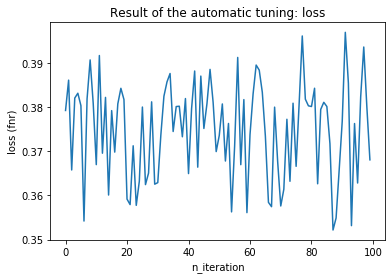

In [113]:
# Plot of the loss through the iterations
fig, ax = plt.subplots()
ax.plot(bayes_trials.losses())
ax.set_title("Result of the automatic tuning: loss")
ax.set_ylabel('loss (fnr)')
ax.set_xlabel('n_iteration')

In [114]:
# Sort the trials with lowest loss (loss) first
trials_dict = sorted(bayes_trials.results, key = lambda x: x['loss'])
best_params = trials_dict[:1][0]['params']
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9303301995762401,
 'learning_rate': 0.015456872200907345,
 'num_leaves': 29,
 'objective': 'binary',
 'reg_alpha': 0.4871246503408576,
 'reg_lambda': 0.6677960719683547}

In [115]:
# Gradient boosting machine classifier with the optimal hyperparameters
best_model_lgb = lgb.LGBMClassifier(**best_params, random_state=42)

# fit the model to the balanced data
best_model_lgb.fit(X_train_std, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9303301995762401, importance_type='split',
               learning_rate=0.015456872200907345, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=29, objective='binary',
               random_state=42, reg_alpha=0.4871246503408576,
               reg_lambda=0.6677960719683547, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [116]:
# Validation performance
y_prob = best_model_lgb.predict_proba(X_test_std)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_prob[:,1])
print("accuracy score : %0.3f" % best_model_lgb.score(X_test_std, y_test))
print("precision score : %0.3f " % np.mean(precision[:-1,]))
print("recall score : %0.3f" % np.mean(recall[:-1,]))
print('false negative ratio : %0.3f' % fnr_prob(y_test, y_prob))

accuracy score : 0.676
precision score : 0.149 
recall score : 0.708
false negative ratio : 0.292


In [117]:
# Save the results in the precedent dictionary
evaluate_performance(y_prob, best_model_lgb, key='LGBM Classifier')

accuracy score : 0.676
false negative ratio : 0.292
precision score : 0.149 
recall score : 0.708


In [118]:
perf_score

{'accuracy_score': {'Decision Tree': 0.6344405963936719,
  'LGBM Classifier': 0.6756255792400371,
  'Logistic regression': 0.6809098743150741,
  'Random Forest': 0.08046761946571712},
 'fnr': {'Decision Tree': 0.3748231966053748,
  'LGBM Classifier': 0.2919163828833039,
  'Logistic regression': 0.27578949511880635,
  'Random Forest': 0.0},
 'precision_score': {'Decision Tree': 0.10139050502671026,
  'LGBM Classifier': 0.14877367500418626,
  'Logistic regression': 0.1533210791186973,
  'Random Forest': 0.08046761946571712},
 'recall_score': {'Decision Tree': 0.6251768033946252,
  'LGBM Classifier': 0.7080836171166961,
  'Logistic regression': 0.7242105048811937,
  'Random Forest': 1.0}}

In [124]:
# Importance of the features from the LGBM model
features_importances = pd.DataFrame(best_model_lgb.feature_importances_, 
                                    index = lgb_feature_names, 
                                    columns = ["Importance"]
                                   ).sort_values("Importance", ascending=False)
features_importances.head(5)

Importance
DAYS_BIRTH                                  268
EXT_SOURCE_2                                261
client_payments_AMT_PAYMENT_min_sum         230
DAYS_EMPLOYED                               176
AMT_CREDIT                                  132

Text(0, 0.5, 'features')

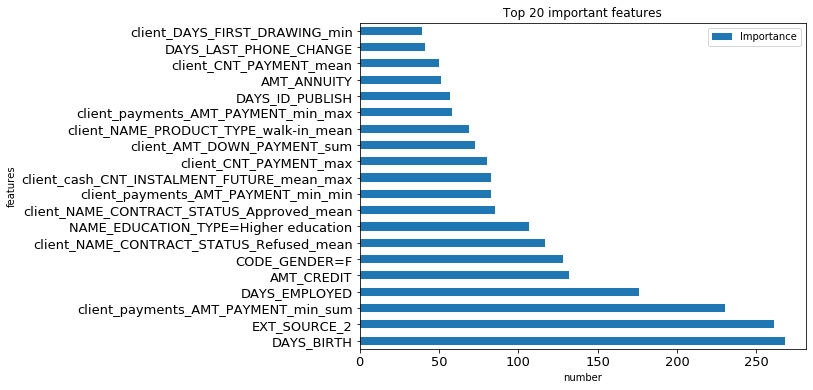

In [125]:
# Plot the top 20 variables
fig, ax = plt.subplots(figsize=(8,6))
features_importances.iloc[:20,:].plot(kind='barh', ax=ax, rot=0, fontsize=13,
                                      title="Top 20 important features")
ax.set_xlabel('number')
ax.set_ylabel('features')

# Final model

We compare the four results in order to select a final model to be deployed.

## Comparison of the model performances

In [119]:
# summarize the results in a df
df_perf = pd.DataFrame({'accuracy_score': pd.Series(perf_score['accuracy_score']),
                        'recall_score': pd.Series(perf_score['recall_score']),
                        'precision score': pd.Series(perf_score['precision_score']),
                        'fnr': pd.Series(perf_score['fnr'])}, index=perf_score['fnr'].keys())

df_perf

accuracy_score  recall_score  precision score       fnr
Logistic regression        0.680910      0.724211         0.153321  0.275789
Decision Tree              0.634441      0.625177         0.101391  0.374823
Random Forest              0.080468      1.000000         0.080468  0.000000
LGBM Classifier            0.675626      0.708084         0.148774  0.291916

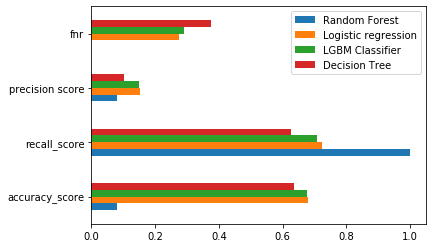

In [123]:
# Plot the different score and loss values by each model
df_perf.sort_values('fnr').T.plot.barh()

**With respect to the FNR, the random forest provides the best results. But this model fails to predict correctly the true labels. So, we use the baseline model (logistic regression) as it provides a relative good accuracy and FNR.**

## Feature ranking

The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

In [0]:
#Feature ranking from the logistic model with recursive feature elimination (RFE)
rfe_selector = RFE(baseline, n_features_to_select=1).fit(X_train_std, y_train)

In [130]:
# Feature ranks from the logistic model
order = rfe_selector.ranking_
features_rank = pd.DataFrame(order, 
                             index = lgb_feature_names, 
                             columns = ["rank"],
                             ).sort_values("rank", ascending=True)
features_rank.head(10)

rank
NAME_INCOME_TYPE=Working                       1
NAME_INCOME_TYPE=Commercial associate          2
DAYS_EMPLOYED                                  3
NAME_INCOME_TYPE=State servant                 4
client_cash_SK_DPD_DEF_mean_min                5
EXT_SOURCE_2                                   6
client_payments_AMT_PAYMENT_min_sum            7
client_cash_CNT_INSTALMENT_FUTURE_mean_max     8
client_NAME_CONTRACT_STATUS_Refused_mean       9
DAYS_BIRTH                                    10

Text(0, 0.5, 'features')

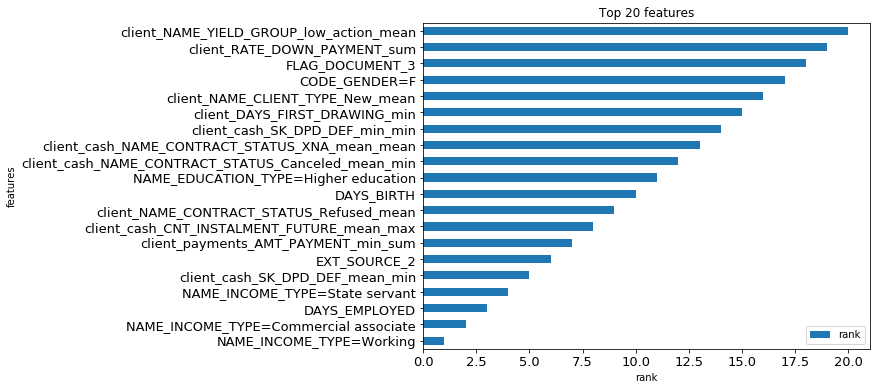

In [136]:
# Plot the top 20 variables
fig, ax = plt.subplots(figsize=(8,6))
features_rank.iloc[:20,:].plot(kind='barh', ax=ax, rot=0, fontsize=13,
                                      title="Top 20 features")
ax.set_xlabel('rank')
ax.set_ylabel('features')

## Store the final results

In [139]:
# save the column names
columns = X_select.iloc[[]]
columns

Empty DataFrame
Columns: [AMT_ANNUITY, AMT_CREDIT, AMT_INCOME_TOTAL, CNT_CHILDREN, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE, DAYS_REGISTRATION, DEF_30_CNT_SOCIAL_CIRCLE, EXT_SOURCE_2, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_18, FLAG_DOCUMENT_3, FLAG_DOCUMENT_6, FLAG_DOCUMENT_8, FLAG_PHONE, FLAG_WORK_PHONE, HOUR_APPR_PROCESS_START, LIVE_CITY_NOT_WORK_CITY, OBS_30_CNT_SOCIAL_CIRCLE, REGION_POPULATION_RELATIVE, REGION_RATING_CLIENT, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, client_cash_MONTHS_BALANCE_sum_sum, client_cash_MONTHS_BALANCE_min_sum, client_cash_MONTHS_BALANCE_min_min, client_cash_SK_DPD_DEF_min_min, client_cash_NAME_CONTRACT_STATUS_Canceled_mean_min, client_cash_NAME_CONTRACT_STATUS_XNA_mean_mean, client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_min, client_cash_SK_DPD_DEF_mean_min, client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_mean, client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_max, client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_sum, client_cash_NAME_CONTRACT_STATUS_Signed_mean_min, client_cash_NAME_CONTRACT_STATUS_Signed_mean_mean, client_cash_CNT_INSTALMENT_FUTURE_min_min, client_cash_CNT_INSTALMENT_FUTURE_min_mean, client_cash_CNT_INSTALMENT_FUTURE_min_max, client_cash_NAME_CONTRACT_STATUS_Completed_mean_min, client_cash_NAME_CONTRACT_STATUS_Completed_mean_max, client_cash_CNT_INSTALMENT_FUTURE_mean_min, client_cash_CNT_INSTALMENT_FUTURE_mean_mean, client_cash_NAME_CONTRACT_STATUS_Completed_mean_sum, client_cash_CNT_INSTALMENT_FUTURE_mean_max, client_cash_CNT_INSTALMENT_count_min, client_cash_CNT_INSTALMENT_min_min, client_cash_CNT_INSTALMENT_count_mean, client_NAME_SELLER_INDUSTRY_MLM partners_mean, client_NAME_CONTRACT_TYPE_XNA_mean, client_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean, client_NAME_CASH_LOAN_PURPOSE_Car repairs_mean, client_NAME_GOODS_CATEGORY_Tourism_mean, client_NAME_CASH_LOAN_PURPOSE_Medicine_mean, client_NAME_CASH_LOAN_PURPOSE_Urgent needs_mean, client_FLAG_LAST_APPL_PER_CONTRACT_N_mean, client_CODE_REJECT_REASON_SCOFR_mean, client_NAME_GOODS_CATEGORY_Medical Supplies_mean, client_NAME_CASH_LOAN_PURPOSE_Repairs_mean, client_NAME_SELLER_INDUSTRY_Industry_mean, client_PRODUCT_COMBINATION_Cash Street: middle_mean, client_CHANNEL_TYPE_Channel of corporate sales_mean, client_NAME_CASH_LOAN_PURPOSE_Payments on other loans_mean, client_NAME_CASH_LOAN_PURPOSE_Other_mean, client_CODE_REJECT_REASON_SCO_mean, client_CODE_REJECT_REASON_HC_mean, client_NAME_SELLER_INDUSTRY_Clothing_mean, client_NAME_TYPE_SUITE_Children_mean, client_CHANNEL_TYPE_Contact center_mean, client_NAME_GOODS_CATEGORY_Computers_mean, client_PRODUCT_COMBINATION_POS industry without interest_mean, client_PRODUCT_COMBINATION_POS household without interest_mean, client_NAME_YIELD_GROUP_low_action_mean, client_PRODUCT_COMBINATION_Cash Street: high_mean, client_CHANNEL_TYPE_AP+ (Cash loan)_mean, client_NAME_PRODUCT_TYPE_walk-in_mean, client_PRODUCT_COMBINATION_Cash X-Sell: middle_mean, client_PRODUCT_COMBINATION_Card Street_mean, client_NAME_SELLER_INDUSTRY_Construction_mean, client_NAME_GOODS_CATEGORY_Construction Materials_mean, client_PRODUCT_COMBINATION_Cash X-Sell: high_mean, client_CODE_REJECT_REASON_LIMIT_mean, client_NAME_CONTRACT_STATUS_Refused_mean, client_PRODUCT_COMBINATION_Card X-Sell_mean, client_NAME_PORTFOLIO_Cards_mean, client_NAME_GOODS_CATEGORY_Audio/Video_mean, client_PRODUCT_COMBINATION_Cash_mean, client_NAME_YIELD_GROUP_XNA_mean, client_CHANNEL_TYPE_Regional / Local_mean, client_NAME_GOODS_CATEGORY_Furniture_mean, client_NAME_GOODS_CATEGORY_Consumer Electronics_mean, client_PRODUCT_COMBINATION_POS industry with interest_mean, client_PRODUCT_COMBINATION_POS household with interest_mean, client_WEEKDAY_APPR_PROCESS_START_SUNDAY_mean, client_NAME_SELLER_INDUSTRY_Consumer electronics_mean, ...]
Index: []

[0 rows x 221 columns]

In [150]:
# Refit the imputer and the scaler to the new shape of X_train
impute_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Normalize with a standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(impute_mean.fit_transform(X_select))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
# store the result in a dict
output = {}
output['columns'] = columns
output['X_train'] = X_train_std
output['class_names'] = list(y.unique())
output['scaler'] = scaler 
output['imputer'] = impute_mean

In [152]:
baseline.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
output['model'] = baseline

In [58]:
output['lgb_model'] = best_lgb_model

In [0]:
# Save to a pickle file in the current working directory
pkl_filename = "pickle_output.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(output, file)

In [164]:
train_set.loc[X_test.index,:].sample(n=100, replace=False, random_state=1)

AMT_ANNUITY  ...  WEEKDAY_APPR_PROCESS_START=WEDNESDAY
150519      20529.0  ...                                     0
78334       22887.0  ...                                     0
113336      42511.5  ...                                     0
210105      30573.0  ...                                     0
32776       61731.0  ...                                     0
...             ...  ...                                   ...
105701      31887.0  ...                                     0
24629        6750.0  ...                                     0
171712      60115.5  ...                                     0
117899      67045.5  ...                                     0
86065        5089.5  ...                                     0

[100 rows x 422 columns]

In [0]:
# select a sample of X_test and store in a csv for the dashboard and the interpretability
train_set.loc[X_test.index,:].sample(n=100, replace=False, random_state=1).to_csv('sample_test.csv', index=False, sep=',')

# Explaining predictions with *Lime*

*lime* is a tool that aim to explain what black box classifier with two or more classes does.

In [1]:
# Import the necessay package
%matplotlib inline

import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Interpretability of the predictions
import lime
import lime.lime_tabular

In [2]:
# Load the pickle file
pkl_filename = "pickle_output.pkl"
with open('./data/'+pkl_filename, 'rb') as file:
    pkl_output = pickle.load(file)

In [3]:
# Assign the pickle objects
df_columns = pkl_output['columns']
feature_names = list(df_columns.columns)
class_names = pkl_output['class_names']
lr_model = pkl_output['model']
lgb_model = pkl_output['lgb_model']
X_train = pkl_output['X_train']
imputer = pkl_output['imputer']
scaler = pkl_output['scaler']

In [4]:
# load the sample test set (100 entries)
df_sample = pd.read_csv('./data/sample_test.csv', sep=',')

In [5]:
df_sample.head()

AMT_ANNUITY  AMT_CREDIT  AMT_INCOME_TOTAL  CNT_CHILDREN  DAYS_BIRTH  \
0      20529.0    555273.0           90000.0             0      -20807   
1      22887.0    312768.0          157500.0             0      -15885   
2      42511.5   1546020.0          148500.0             0      -18410   
3      30573.0    450000.0          225000.0             0      -15230   
4      61731.0    924858.0          135000.0             0      -20624   

   DAYS_EMPLOYED  DAYS_ID_PUBLISH  DAYS_LAST_PHONE_CHANGE  DAYS_REGISTRATION  \
0         365243            -3844                     0.0           -14922.0   
1          -3971            -4912                  -349.0            -8467.0   
2          -3755            -1968                 -1809.0            -9424.0   
3           -366            -4227                  -352.0            -6956.0   
4          -4522            -3594                  -175.0            -8756.0   

   DEF_30_CNT_SOCIAL_CIRCLE  ...  WALLSMATERIAL_MODE=Panel  \
0                       0.0  ...                         0   
1                       0.0  ...                         1   
2                       0.0  ...                         0   
3                       0.0  ...                         1   
4                       0.0  ...                         1   

   WALLSMATERIAL_MODE=Stone, brick  WALLSMATERIAL_MODE=Wooden  \
0                                1                          0   
1                                0                          0   
2                                1                          0   
3                                0                          0   
4                                0                          0   

   WEEKDAY_APPR_PROCESS_START=FRIDAY  WEEKDAY_APPR_PROCESS_START=MONDAY  \
0                                  0                                  0   
1                                  1                                  0   
2                                  1                                  0   
3                                  0                                  0   
4                                  0                                  1   

   WEEKDAY_APPR_PROCESS_START=SATURDAY  WEEKDAY_APPR_PROCESS_START=SUNDAY  \
0                                    1                                  0   
1                                    0                                  0   
2                                    0                                  0   
3                                    0                                  1   
4                                    0                                  0   

   WEEKDAY_APPR_PROCESS_START=THURSDAY  WEEKDAY_APPR_PROCESS_START=TUESDAY  \
0                                    0                                   0   
1                                    0                                   0   
2                                    0                                   0   
3                                    0                                   0   
4                                    0                                   0   

   WEEKDAY_APPR_PROCESS_START=WEDNESDAY  
0                                     0  
1                                     0  
2                                     0  
3                                     0  
4                                     0  

[5 rows x 422 columns]

In [6]:
# Align with the columns used to train the model
df_align, _ = df_sample.align(df_columns, join='right', axis=1)

In [7]:
# Apply the same imputer and scaler functions before predicting
X_test = scaler.transform(imputer.transform(df_align))
X_test.shape

(100, 221)

In [8]:
# make sure the class names are ordered
class_names = ['0', '1']

In [9]:
# The predict function to be called in the explainer

# possible to include directly the imputer and the scaler
#predict_fn = lambda x: lr_model.predict_proba(scaler.transform(imputer.transform(x))).astype(float)

# or use the transformed array
predict_fn = lambda x: lr_model.predict_proba(x).astype(float)

In [10]:
# The lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names,
                                                   class_names=class_names, 
                                                   kernel_width=3)

In [11]:
# Interpretation for an entry i
i = 2
#exp = explainer.explain_instance(df_align.iloc[i,:], predict_fn, num_features=6)
exp = explainer.explain_instance(X_test[i], predict_fn, num_features=6)

In [12]:
# predicted probabilities for classes '0' and '1'
pred = exp.predict_proba
pred

array([0.60219575, 0.39780425])

In [13]:
# Predict and compare the results
prob = lr_model.predict_proba(X_test[[i]])
pred = lr_model.predict(X_test[[i]])
print("predicted class : ", pred)
print("probabilities : ", prob)

predicted class :  [0.]
probabilities :  [[0.60219575 0.39780425]]


In [14]:
exp.show_in_notebook(show_all=False)

In [15]:
# Export the result in a pandas series
exp_list = exp.as_list()
tab = pd.Series(dict(exp.as_list()), index=dict(exp.as_list()).keys())
list_color = tab.apply(lambda x: 'green' if x<0 else 'red').values
list_color

array(['green', 'red', 'green', 'green', 'green', 'green'], dtype=object)

Text(0, 0.5, 'features')

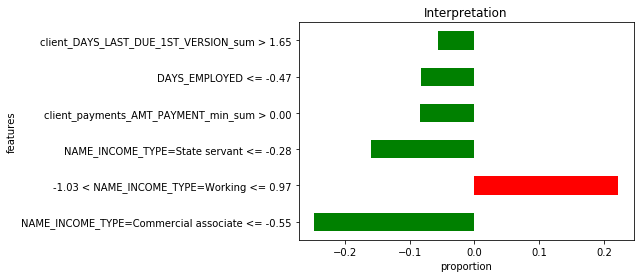

In [16]:
# barplot of the series
fig, ax = plt.subplots()
tab.plot.barh(color=list_color, ax=ax)
ax.set_title("Interpretation")
ax.set_xlabel('proportion')
ax.set_ylabel('features')

**The interpreation of the prediction shows that the client 2 has 60% of chance to be a good client. However, his social category (work) affects negatively this probability.**